In [1]:
import torch
import torch.nn as nn
import torch.distributions as distrib
import torchvision.transforms as transforms
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

# Number of classes in the dataset
num_classes = 10

In [4]:
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
        
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

### Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        num_channels = 1
        num_classes = 10
        in_channels = num_channels 

        self.model = nn.Sequential(
            # Convolutional layer, from 1x28x28 into 16x14x14 tensor
            nn.Conv2d(num_channels, 16, kernel_size=4, stride=2, padding=1),
            # Batch normalization
            nn.BatchNorm2d(16),
            # Leaky ReLU activation
            nn.LeakyReLU(0.01),
            #nn.Dropout(0.3),
            # Convolutional layer, from 16x14x14 into 32x7x7 tensor
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            # Batch normalization
            nn.BatchNorm2d(32),     
            # Leaky ReLU activation
            nn.LeakyReLU(0.01),
            #nn.Dropout(0.3),
            #nn.Conv2d(32,1,kernel_size=7,stride=1),
            # 32x7x7 -> 1568
            nn.Flatten(start_dim=1),
            nn.Linear(32*7*7, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(0.01),
            nn.Linear(100, 1),

            #nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1),
            # Batch normalization
            #nn.BatchNorm2d(256),     
            # Leaky ReLU activation
            #nn.LeakyReLU(0.01),
  
            # Output layer with sigmoid activation
            #nn.Flatten(),
            #nn.Sigmoid()
        )


    def forward(self, x):
        # convertit le tenseur (batch, 784) en (batch, 1, 28, 28)
        x = x.view(x.size(0), 1, 28, 28)
        #x = x.Reshape(1,28,28)
        #c = self.label_embedding(labels)
        #c = c.view(x.size(0), 10, 28, 28)
        #c = c.Reshape(10,28,28)
        #x = torch.cat([x, c], dim=1)
        output = self.model(x)
        #output = output.view(len(output),1)
        # applatit toutes les dimensions à partir de la n°1 en une seule dimension
        # convertit un tenseur (batch, 1, 1, 1) en un tenseur (batch, 1)
        #output = output.flatten(start_dim=1)
        return output

In [6]:
discriminator = Discriminator().to(device)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1568, out_features=100, bias=True)
    (8): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=100, out_features=1, bias=True)
  )
)


### Generator

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        latent_dim = 100
        num_classes = 10
        input_dim = latent_dim 

        self.model = nn.Sequential(
            # Reshape input into 7x7x256 tensor via a fully connected layer
            #nn.Linear(z_dim,256*7*7),
            #Reshape((256,7,7,)),
            #nn.BatchNorm1d(7*7*256),
            #nn.ReLU(),
            #  100x1x1 -> 128x7x7
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=7,stride=1),#,padding=1,output_padding=1)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
            # 128x7x7 -> 64x14x14
            nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1),  #,padding=1,output_padding=1),
            # Batch normalization
            nn.BatchNorm2d(64),
            # Leaky ReLU activation
            nn.ReLU(),
            # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
            # 64x14x14 -> 32x28x28
            nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1),   #,padding=1),
            # Batch normalization
            nn.BatchNorm2d(32),
            # Leaky ReLU activation
            nn.ReLU(),
            # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
            #nn.ConvTranspose2d(64,1,kernel_size=4,stride=2),   #,padding=1,output_padding=1),
            nn.Conv2d(32, 1, kernel_size=5, stride=1, padding=2),
            # Output layer with tanh activation
            nn.Tanh()
        )
        

    def forward(self, x):
        #c = self.label_embedding(labels)
        #x = torch.cat([x,c], 1)
        #output = self.fc(x)
        #output = output.view(-1, 256, 7, 7)
        x=x.view(x.size(0),z_dim,1,1)
        output = self.model(x)
        #output = output.view(-1, 1, 28, 28)
        return output

In [8]:
generator = Generator().to(device)
print(generator)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): Tanh()
  )
)


### Training

In [9]:
lr = 1e-4
num_epochs = 50
loss_function = nn.BCEWithLogitsLoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr,betas = (0.5,0.9))   
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr,betas = (0.5,0.9))

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 32
# Load the training set
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a batched data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [11]:
latent_space_samples_plot = torch.randn((batch_size, 100)).to(device=device)

Epoch: 0 Loss D.: 0.7221583724021912
Epoch: 0 Loss G.: 0.5528327226638794


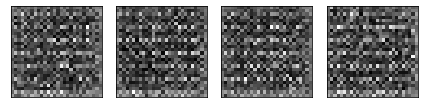

Epoch: 1 Loss D.: 0.4196999669075012
Epoch: 1 Loss G.: 1.1463353633880615


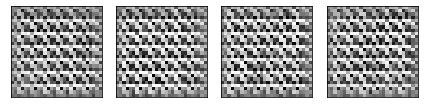

Epoch: 2 Loss D.: 0.49612635374069214
Epoch: 2 Loss G.: 1.062564492225647


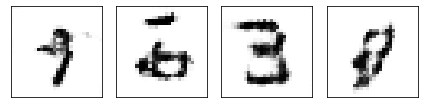

Epoch: 3 Loss D.: 0.5272008180618286
Epoch: 3 Loss G.: 1.0051453113555908


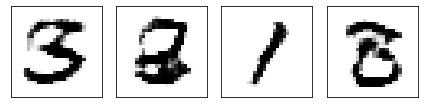

Epoch: 4 Loss D.: 0.4981709420681
Epoch: 4 Loss G.: 1.0217640399932861


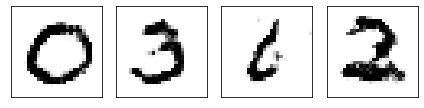

Epoch: 5 Loss D.: 0.5417704582214355
Epoch: 5 Loss G.: 1.0576390027999878


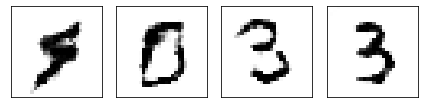

Epoch: 6 Loss D.: 0.5083706378936768
Epoch: 6 Loss G.: 1.0675400495529175


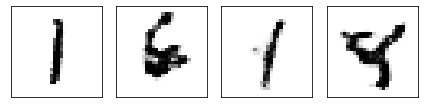

Epoch: 7 Loss D.: 0.5127840042114258
Epoch: 7 Loss G.: 1.1597623825073242


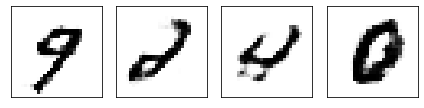

Epoch: 8 Loss D.: 0.49421030282974243
Epoch: 8 Loss G.: 1.3746687173843384


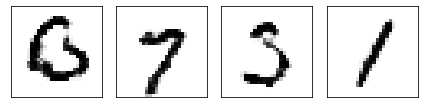

Epoch: 9 Loss D.: 0.41681867837905884
Epoch: 9 Loss G.: 1.2035102844238281


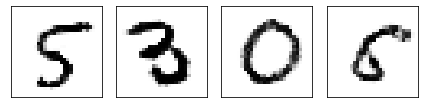

Epoch: 10 Loss D.: 0.45618265867233276
Epoch: 10 Loss G.: 1.2510566711425781


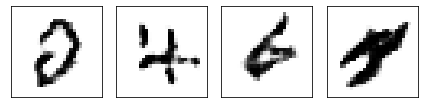

Epoch: 11 Loss D.: 0.4390942454338074
Epoch: 11 Loss G.: 1.1524837017059326


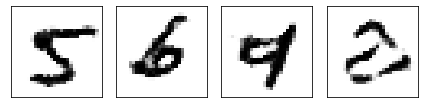

Epoch: 12 Loss D.: 0.5549553036689758
Epoch: 12 Loss G.: 1.2128362655639648


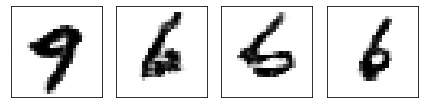

Epoch: 13 Loss D.: 0.5056672096252441
Epoch: 13 Loss G.: 1.1505851745605469


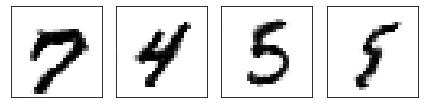

Epoch: 14 Loss D.: 0.5502544641494751
Epoch: 14 Loss G.: 1.0560567378997803


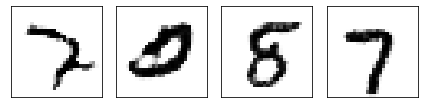

Epoch: 15 Loss D.: 0.4638262391090393
Epoch: 15 Loss G.: 1.2099225521087646


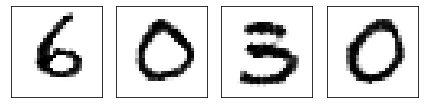

Epoch: 16 Loss D.: 0.47287970781326294
Epoch: 16 Loss G.: 1.3028194904327393


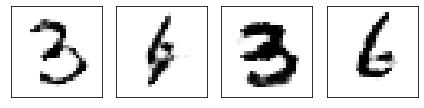

Epoch: 17 Loss D.: 0.5207928419113159
Epoch: 17 Loss G.: 1.0681304931640625


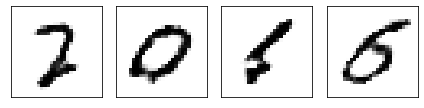

Epoch: 18 Loss D.: 0.46119487285614014
Epoch: 18 Loss G.: 1.1657159328460693


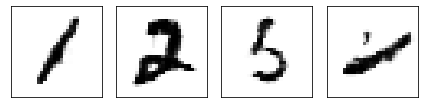

Epoch: 19 Loss D.: 0.6212744116783142
Epoch: 19 Loss G.: 1.0466501712799072


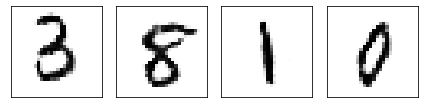

Epoch: 20 Loss D.: 0.6292608976364136
Epoch: 20 Loss G.: 1.2284367084503174


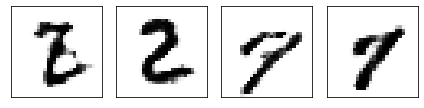

Epoch: 21 Loss D.: 0.540235161781311
Epoch: 21 Loss G.: 1.12518310546875


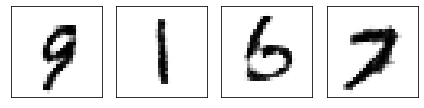

Epoch: 22 Loss D.: 0.4834473729133606
Epoch: 22 Loss G.: 1.1507858037948608


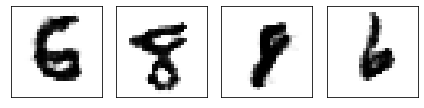

Epoch: 23 Loss D.: 0.5997222661972046
Epoch: 23 Loss G.: 1.385875940322876


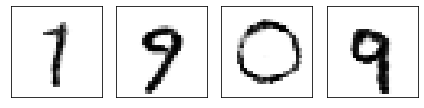

Epoch: 24 Loss D.: 0.4591829180717468
Epoch: 24 Loss G.: 1.3169293403625488


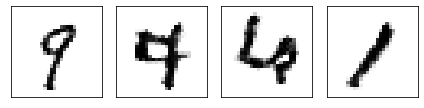

Epoch: 25 Loss D.: 0.3266558051109314
Epoch: 25 Loss G.: 1.6570563316345215


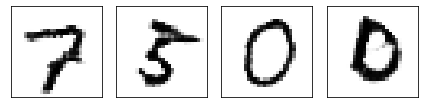

Epoch: 26 Loss D.: 0.5018584728240967
Epoch: 26 Loss G.: 1.400820255279541


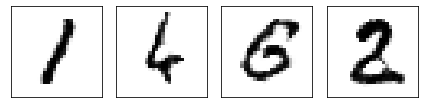

Epoch: 27 Loss D.: 0.4734605848789215
Epoch: 27 Loss G.: 1.3601399660110474


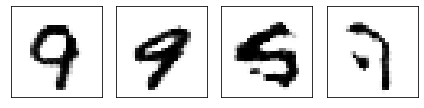

Epoch: 28 Loss D.: 0.4844978153705597
Epoch: 28 Loss G.: 1.0659204721450806


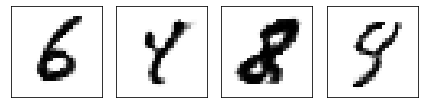

Epoch: 29 Loss D.: 0.3725380301475525
Epoch: 29 Loss G.: 1.8427762985229492


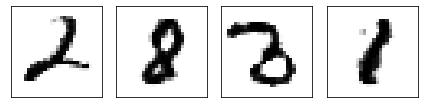

Epoch: 30 Loss D.: 0.5089418888092041
Epoch: 30 Loss G.: 1.6353380680084229


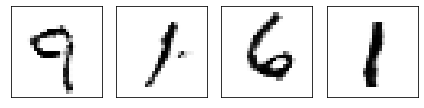

Epoch: 31 Loss D.: 0.5080878734588623
Epoch: 31 Loss G.: 1.289002537727356


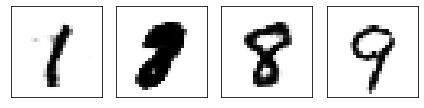

Epoch: 32 Loss D.: 0.5618315935134888
Epoch: 32 Loss G.: 1.1274478435516357


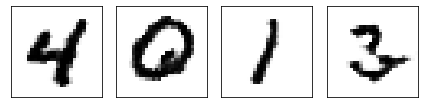

Epoch: 33 Loss D.: 0.4121370315551758
Epoch: 33 Loss G.: 1.6620055437088013


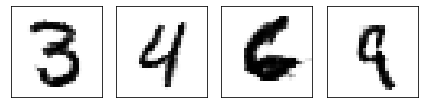

Epoch: 34 Loss D.: 0.4694508910179138
Epoch: 34 Loss G.: 1.2268085479736328


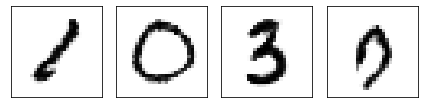

Epoch: 35 Loss D.: 0.2766648828983307
Epoch: 35 Loss G.: 1.8562114238739014


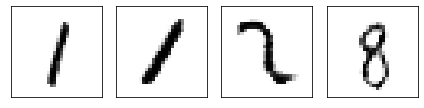

Epoch: 36 Loss D.: 0.4499971866607666
Epoch: 36 Loss G.: 1.6202738285064697


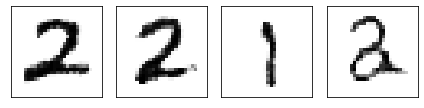

Epoch: 37 Loss D.: 0.4486564099788666
Epoch: 37 Loss G.: 1.322317361831665


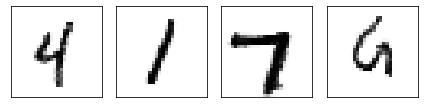

Epoch: 38 Loss D.: 0.42501574754714966
Epoch: 38 Loss G.: 1.2548723220825195


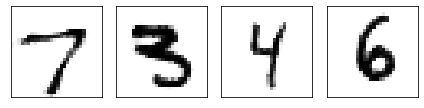

Epoch: 39 Loss D.: 0.36300528049468994
Epoch: 39 Loss G.: 1.4569857120513916


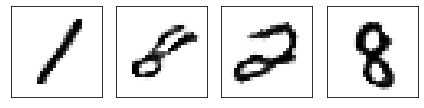

Epoch: 40 Loss D.: 0.4801938533782959
Epoch: 40 Loss G.: 1.1713995933532715


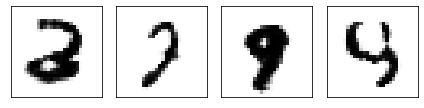

Epoch: 41 Loss D.: 0.3276708722114563
Epoch: 41 Loss G.: 1.6175309419631958


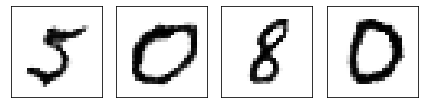

Epoch: 42 Loss D.: 0.5947319865226746
Epoch: 42 Loss G.: 1.277773380279541


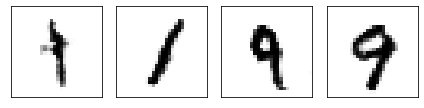

Epoch: 43 Loss D.: 0.5311218500137329
Epoch: 43 Loss G.: 1.176604151725769


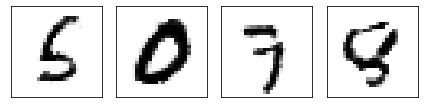

Epoch: 44 Loss D.: 0.3757902979850769
Epoch: 44 Loss G.: 1.2687525749206543


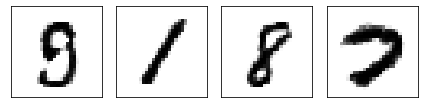

Epoch: 45 Loss D.: 0.4686470627784729
Epoch: 45 Loss G.: 1.6022919416427612


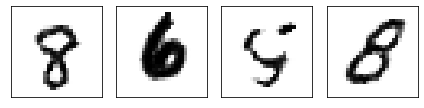

Epoch: 46 Loss D.: 0.4382648468017578
Epoch: 46 Loss G.: 1.6878228187561035


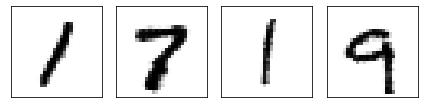

Epoch: 47 Loss D.: 0.3877968192100525
Epoch: 47 Loss G.: 1.8242586851119995


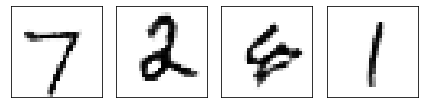

Epoch: 48 Loss D.: 0.5266129970550537
Epoch: 48 Loss G.: 1.6488792896270752


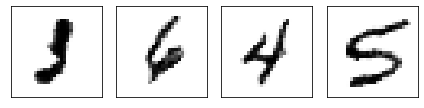

Epoch: 49 Loss D.: 0.41557198762893677
Epoch: 49 Loss G.: 1.5864496231079102


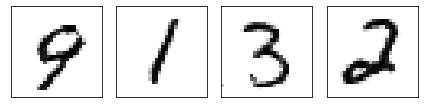

In [12]:
import os

loss_d = np.zeros(num_epochs)
loss_g = np.zeros(num_epochs)

# Load trained NN when it exists, or train a new NN
if os.path.isfile('discriminator.pt') and os.path.isfile('generator.pt'):
    discriminator.load_state_dict(torch.load('./discriminator.pt'))
    generator.load_state_dict(torch.load('./generator.pt'))   
else:
    for epoch in range(num_epochs):
      for n, (real_samples, mnist_labels) in enumerate(train_loader):
          ##############################
          ## update the discriminator
          ##############################
          batch_size = real_samples.size(0)
          noise = torch.randn((batch_size, 100))
          noise = noise.to(device)

          real_samples = real_samples.to(device)
          mnist_labels = mnist_labels.to(device)
          
          # zero the parameter gradients
          optimizer_discriminator.zero_grad()
          
          # forward du generator, creation d'un batch de fake samples (noise, puis passage dans generateur)
          fake_samples = generator(noise)
          
          # forward du discriminator

          disc_real_output = discriminator(real_samples)
          #print(fake_samples.size())
          disc_fake_output = discriminator(fake_samples.detach()) # on detach fake_samples, car on n'a pas 
                                                                                # besoin d'avoir accès au gradient du generateur
          
          # calculate the loss for the discriminator
          loss_discriminator = 1/2 * (loss_function(disc_real_output, torch.ones_like(disc_real_output)) + loss_function(disc_fake_output, torch.zeros_like(disc_fake_output)))
          loss_d[epoch] = loss_discriminator
          # calculate the gradient for the discriminator
          loss_discriminator.backward()  
          
          # update the discriminator first
          optimizer_discriminator.step()
          
          ##############################
          ## update the Generator
          ##############################
          
          # zero the parameter gradients
          optimizer_generator.zero_grad()

          # forward du discriminator
          # on ne detach pas fake_samples, car on veut garder les gradient pour pouvoir entrainer le generateur
          #print(fake_samples.size())
          disc_fake_output = discriminator(fake_samples)
          
          # calculate the loss for the generator
          loss_generator = loss_function(disc_fake_output, torch.ones_like(disc_fake_output),)
          loss_g[epoch] = loss_generator
          # calculate the gradient for the discriminator
          loss_generator.backward() 
          
          # update the generator
          optimizer_generator.step()

          # Show loss
          if n == batch_size - 1:
              print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
              print(f"Epoch: {epoch} Loss G.: {loss_generator}")
              
              latent_space_samples = torch.randn(batch_size, 100).to(device=device)

              generated_samples = generator(latent_space_samples)
              generated_samples = generated_samples.cpu().detach()

              plt.figure()
              for i in range(4):
                  ax = plt.subplot(1, 4, i+1)
                  plt.imshow(generated_samples[i].reshape(28, 28), cmap='gray_r')
                  plt.xticks([])
                  plt.yticks([])
              plt.tight_layout()
              plt.show()

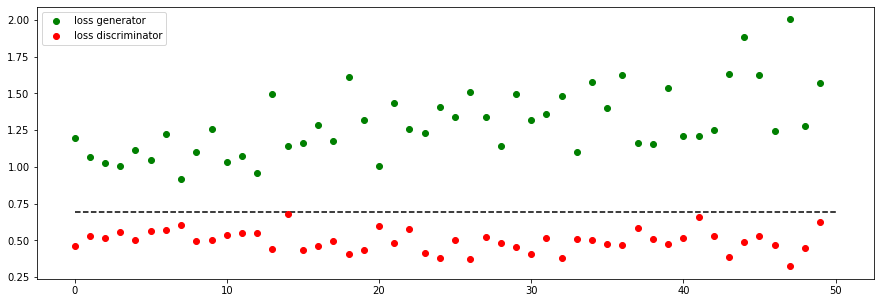

In [13]:
plt.figure(figsize=(15,5))
plt.plot(loss_g,'go', label = "loss generator")
plt.plot(loss_d, 'ro', label = "loss discriminator")
plt.hlines(0.69, 0,50,color='black', linestyle ='--')
plt.legend()

discriminateur mauvais ? loss tjrs pas très loin de 0.69

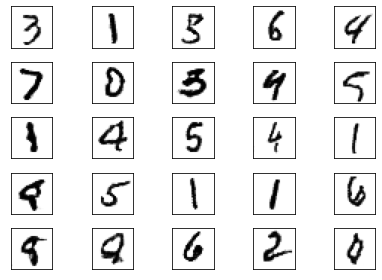

In [15]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)

generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach()

plt.figure()
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()